In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data"))
import zipfile
import sys
import time

from keras import backend, models, layers, initializers, regularizers, constraints, optimizers
from keras import callbacks as kc
from keras import optimizers as ko

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import log_loss
import time


dense_layer_sizes = [37]
dropout_rate = 0.6
learning_rate = 0.001
n_fold = 5
batch_size = 32
epochs = 1000
patience = 100
# n_test = 100
lambd = 0.1 # L2 regularization

['sample_submission_stage_1.csv', 'test_stage_1.tsv', 'trees']


Using TensorFlow backend.


# The features are from this [awesome kernel](https://www.kaggle.com/pheell/look-ma-no-embeddings)


In [2]:
import spacy
import pandas as pd
import numpy as np
nlp = spacy.load('en_core_web_lg')

# Load the GAP data

data = pd.concat([pd.read_csv('gap-development.tsv', sep='\t'),
                  pd.read_csv('gap-validation.tsv', sep='\t'),
                  pd.read_csv('gap-test.tsv', sep='\t')
                 ], ignore_index = True)

In [3]:
def domain(t):
    while not t._.subj and not t._.poss and\
            not (t.dep_ == 'xcomp' and t.head._.obj) and\
            t != t.head:
        t = t.head
    return t

def ccom(t):
    return [t2 for t2 in t.head._.d]

# spacy extensions:
#   doc._.to(offset) => t at text char offset
#   t._.c => t's children (list)                     #   t._.d => t's descendents (list)
#   t._.subj => t's subject else False               #   t._.obj => t's object else False
#   t._.domain => t's syntactic domain               #   t._.ccom => t's c-command domain

spacy.tokens.doc.Doc.set_extension(
    'to', method=lambda doc, offset: [t for t in doc if t.idx == offset][0], force=True)
spacy.tokens.token.Token.set_extension(
    'c', getter=lambda t: [c for c in t.children], force=True)
spacy.tokens.token.Token.set_extension(
    'd', getter=lambda t: [c for c in t.sent if t in list(c.ancestors)], force=True)
spacy.tokens.token.Token.set_extension(
    'subj', getter=lambda t: ([c for c in t._.c if c.dep_.startswith('nsubj')] + [False])[0], force=True)
spacy.tokens.token.Token.set_extension(
    'obj', getter=lambda t: ([c for c in t._.c if c.dep_.startswith('dobj')] + [False])[0], force=True)
spacy.tokens.token.Token.set_extension(
    'poss', getter=lambda t: ([c for c in t._.c if c.dep_.startswith('poss')] + [False])[0], force=True)
spacy.tokens.token.Token.set_extension(
    'span', method=lambda t, t2: t.doc[t.i:t2.i] if t.i < t2.i else t.doc[t2.i:t.i], force=True)
spacy.tokens.token.Token.set_extension('domain', getter=domain, force=True)
spacy.tokens.token.Token.set_extension('ccom', getter=ccom, force=True)

def applyDisq(condition, candidates, candidate_dict, debug = False):
    badnames = sum([nameset(c, candidate_dict) for c in candidates if c in condition[0]], [])
    badcands = [c for c in candidates if c.text in badnames]
    if debug and len(badcands) > 0: print('Disqualified:', badcands, '<', condition[1])
    return [c for c in candidates if c not in badcands]

# Apply a list of disqualifying conditions
def applyDisqs(conditions, candidates, candidate_dict, debug = False):
    for condition in conditions:
        if len(candidates) < 1: return candidates
        candidates = applyDisq(condition, candidates, candidate_dict, debug)
    return candidates

# Pass the list of disqualifying conditions for possessive pronouns (his, her)
def disqGen(t, candidates, candidate_dict, debug = False):
    conds = [(t._.ccom,
             "disqualify candidates c-commanded by genpn; e.g. e.g. *Julia read his_i book about John_i's life."),
             ([t2 for t2 in candidates if t in t2._.ccom and t2.head.dep_ == 'appos'],
             "disqualify candidates modified by an appositive with genpn; e.g. *I wanted to see John_i, his_i father.")
            ]
    return applyDisqs(conds, candidates, candidate_dict, debug)

# Pass the list of list of disqualifying conditions for other pronouns
def disqOthers(t, candidates, candidate_dict, debug = False):
    conds = [([t2 for t2 in t._.ccom if t2.i > t.i],
             "disqualify candidates c-commanded by pn, unless they were preposed;\
             e.g. *He_i cried before John_i laughed. vs. Before John_i laughed, he_i cried."),
             ([t2 for t2 in candidates if t in t2._.ccom and t2._.domain == t._.domain
              and not (t.head.text == 'with' and t.head.head.lemma_ == 'take')],
             "disqualify candidates that c-command pn, unless in different domain;\
             e.g. Mary said that *John_i hit him_i. vs. John_i said that Mary hit him_i;\
             random hard-coded exception: `take with'"),
             ([t2 for t2 in candidates if t2._.domain.dep_ == 'xcomp' and t2._.domain.head._.obj and t2 == t2._.domain.head._.obj],
             "for xcomps with subjects parsed as upstairs dobj, disallow coref with that dobj;\
             e.g. *Mary wanted John_i to forgive him_i.")
            ]
    return applyDisqs(conds, candidates, candidate_dict, debug)

# Decide whether possessive or not and call appropriate function
def disq(t, candidates, candidate_dict, debug = False):
    func = disqGen if t.dep_ == 'poss' else disqOthers
    candidates = func(t, candidates, candidate_dict, debug)
    return candidates

def find_head(w, wo, doc):
    t = False; backtrack = 0
    while not t:
        try:
            t = doc._.to(wo)
        except IndexError:
            wo -= 1; backtrack += 1
    while t.dep_ == 'compound' and t.head.idx >= wo and t.head.idx < len(w) + wo + backtrack: t = t.head
    return t

# Returns subsequences of a name
def subnames(name):
    if type(name) != str: name = candidate_dict[name]
    parts = name.split(' ')
    subnames_ = []
    for i in range(len(parts)): 
        for j in range(i + 1, len(parts) + 1): 
            sub = ' '.join(parts[i:j])
            if len(sub) > 2: subnames_.append(sub)
    return subnames_

# Returns subsequences of a name unless potentially ambiguous (if another candidate picks out same subsequence)
def nameset(name, candidate_dict):
    if type(name) != str: name = candidate_dict[name]
    subnames_ = [sn for sn in subnames(name)]
    return [c for c in subnames_ if c not in sum([subnames(c) for c in candidate_dict.values() 
                                                  if c not in subnames_ and name not in subnames(c)], [])]

# Given the original candidate dict and the final candidate list, returns new dict grouping putative candidate instances under a single key
def candInstances(candidates, candidate_dict):
    candidates_by_name = {}
    for c in sorted(candidates, key = lambda c: len(candidate_dict[c]), reverse = True):
        name = candidate_dict[c]
        for name2 in candidates_by_name.keys():
            if name in nameset(name2, candidate_dict): name = name2; break
        candidates_by_name[name] = candidates_by_name.get(name, []) + [c]
    return candidates_by_name

import gender_guesser.detector as gender # oops
gd = gender.Detector()

# Needed to prune candidate dict-- removes non-provided candidates that don't match in most common gender with pn
def filterGender(candidates_by_name, a, b, pn):
    badnames = []
    gender = 'female' if pn in ['She', 'she', 'her', 'Her'] else 'male'
    for name in candidates_by_name.keys():
        if a in subnames(name) or b in subnames(name): continue
        genderii = gd.get_gender(name.split(' ')[0])
        if gender == 'male' and genderii == 'female': badnames += [name]; continue
        if gender == 'female' and genderii == 'male': badnames += [name]; continue
    for name in badnames: candidates_by_name.pop(name)
    return candidates_by_name

from urllib.parse import unquote
import re

# Authors' metric 1: Does the Wikipedia url contain the candidate's name?
def urlMatch(a, b, url, candidate_dict):
    url = re.sub('[^\x00-\x7F]', '*', unquote(url.split('/')[-1])).replace('_', ' ').lower()
    return {'a_url': (sorted([len(n.split(' ')) for n in nameset(a.lower(), candidate_dict) if n in nameset(url, candidate_dict)], reverse = True) + [0])[0],
            'b_url': (sorted([len(n.split(' ')) for n in nameset(b.lower(), candidate_dict) if n in nameset(url, candidate_dict)], reverse = True) + [0])[0]}

# Authors' metric 2: When pn is subject or object, does the candidate match?
def parallel(t1, t2):
    if t1.dep_.startswith('nsubj'): return t2.dep_.startswith('nsubj')
    if t1.dep_.startswith('dobj'): return t2.dep_.startswith('dobj')
    if t1.dep_.startswith('dative'): return t2.dep_.startswith('dative')
    return False

# Depth from a node to a parent node
def depthTo(t1, t2):
    depth = 0
    while t1 != t2 and t1 != t1.head:
        t1 = t1.head
        depth += 1
    return depth

# Syntactic distance within a single tree
def nodeDist(t1, t2):
    if t1 == t2: return 0
    if t2 in t1._.d: return depthTo(t2, t1)
    if t1 in t2._.d: return depthTo(t1, t2)
    t = t1
    while t1 not in t._.d or t2 not in t._.d and t != t.head: t = t.head
    return depthTo(t1, t) + depthTo(t2, t)

# Authors' metric 3: Syntactic distance (within or across trees)
def synDist(t, pn, doc, debug = False):
    doc_sents = list(doc.sents)
    sspan = doc_sents.index(pn.sent) - doc_sents.index(t.sent)
    if sspan == 0: # same sentence
        dist = nodeDist(t, pn)
    else: # different sentence
        dist = nodeDist(pn, doc_sents[doc_sents.index(pn.sent)].root) + nodeDist(t, doc_sents[doc_sents.index(t.sent)].root) # dist from two roots
    if debug: 
        print('pn dist:', nodeDist(pn, doc_sents[doc_sents.index(pn.sent)].root), '; t dist:',
              nodeDist(t, doc_sents[doc_sents.index(t.sent)].root), '; span:', sspan)
    sspan = abs(sspan) * 1 if sspan >= 0 else abs(sspan) * 1.3 # less local if not preceding
    return dist + sspan# * 0.7

# Character distance
def charDist(t1, t2):
    if t2.idx > t1.idx:
        return t2.idx - t1.idx + len(t1.text)
    else:
        return (t1.idx - t2.idx + len(t2.text)) * 1.3

# Theta prominence: assign a 0.1 to 1 score based on dep role of candidate -- strong feature
def thetaProminence(t, mult = 1, debug = False):
    while t.dep_ == 'compound': t = t.head
    if debug: print('t dep_:', t.dep_)
    if t.dep_ == 'pobj': mult = 1.3 if t.head.i < t.head.head.i else 1
    if t._.domain.dep_ == 'advcl': mult = 1.3 if t.head.i < t._.domain.head.i else 1
    if t.dep_.startswith('nsubj'): score = 1
    elif t.dep_.startswith('dobj'): score = 0.8
    elif t.dep_.startswith('dative'): score = 0.6
    elif t.dep_.startswith('pobj'): score = 0.4
    elif t.dep_.startswith('poss'): score = 0.3
    else: score = 0.1
    if debug: print('mult:', mult, '; score:', score)
    return min(1, score * mult)

# Computes these metrics for each candidate, and returns, for each group of instances (A instances, B instances,\
# other instances), either the sum, or the highest difference from the mean
def score(label, candidates_by_name, a_cand, b_cand, func, minsc = None, method = 'sum'):
    if method == 'sum':
        scores = {name: sum([func(t) for t in tokens]) for name, tokens in candidates_by_name.items()}
    elif method == 'meandiff':
        mean = np.mean(sum([[func(t) for t in tokens] for tokens in candidates_by_name.values()], []))
        scores = {name: mean - min([func(t) for t in tokens]) for name, tokens in candidates_by_name.items()}
    sca = scores[a_cand] if a_cand else minsc
    scb = scores[b_cand] if b_cand else minsc
    screst = [v for n, v in scores.items() if n != a_cand and n != b_cand]
    if method == 'sum':
        screst = sum(screst) if len(screst) > 0 else minsc
    elif method == 'meandiff':
        screst = max(screst) if len(screst) > 0 else minsc
    return {'a_' + label: sca, 'b_' + label: scb, 'n_' + label: screst}

from tqdm import tqdm_notebook as tqdm

# Load a rowfull of data
def load_row(data, i):
    return tuple(data.iloc[i])

# Row by row, populate features
def annotateSet(data, minsc = None, debug = False):
    
    annotated_data = pd.DataFrame() # init placeholder df
    row_batch = []

    for i in tqdm(range(annotated_data.shape[0], data.shape[0])):
        id, text, pn, pno, a, ao, ag, b, bo, bg, url = load_row(data, i)        
        doc = nlp(text) # parse text into doc
        pnt, at, bt = (doc._.to(pno), find_head(a, ao, doc), find_head(b, bo, doc)) # get the tokens that correspond to offsets
        candidate_dict = {e.root: re.sub('\'s$', '', e.text) for e in [e for e in doc.ents if e.root.ent_type_ == 'PERSON']} # first get every PERSON ent as candidate
        candidate_dict.update({c.root: re.sub('\'s$', '', c.text) for c in doc.noun_chunks if c.root.pos_ == 'PROPN' and c.text in sum([subnames(n) for n in candidate_dict.values()], []) and
                               c.root not in candidate_dict.keys()}) # get some missed ones by looking at noun chunks with PROPN roots whose text match part of a candidate but are not already in list
        candidate_dict.update({t: w for t, w in [(at, a), (bt, b)]}) # add provided cands, overwriting in the process

        candidates = disq(pnt, list(candidate_dict.keys()), candidate_dict, debug = False)
        candidates_by_name = candInstances(candidates, candidate_dict)
        candidates_by_name = filterGender(candidates_by_name, a, b, pn)
        a_cand = ([name for name, tokens in candidates_by_name.items() if at in tokens] + [False])[0]
        b_cand = ([name for name, tokens in candidates_by_name.items() if bt in tokens] + [False])[0]
    
        # init row dict
        features = {'id': id, 'label': 0 if ag else 1 if bg else 2}
        # eliminated or not
        features.update({'a_out': 0 if a_cand else 1, 'b_out': 0 if b_cand else 1})
        # url match or not
        features.update(urlMatch(a, b, url, candidate_dict))
        # c-command or not
        features.update({'a_cc': 1 if a_cand and pnt in at._.ccom else 0, 'b_cc': 1 if b_cand and pnt in bt._.ccom else 0})
        # parallelism score
        features.update(score('par', candidates_by_name, a_cand, b_cand, lambda t: parallel(t, pnt), minsc = minsc))
        # theta prominence score
        features.update(score('th', candidates_by_name, a_cand, b_cand, thetaProminence, minsc = minsc))
        # syntactic distance score
        features.update(score('loc', candidates_by_name, a_cand, b_cand, lambda t: synDist(t, pnt, doc), method='meandiff', minsc = minsc))
        # number of candidates left
        features.update({'n_cands': len(candidates_by_name)})
        # char dist
        features.update(score('cloc', candidates_by_name, a_cand, b_cand, lambda t: charDist(t, pnt), method='meandiff', minsc = minsc))

        if debug: print(id, '>', 'a:', 1 if ag else 0, 'b:', 1 if bg else 0, features)
        row_batch += [features]

    # add rows to placeholder df
    if annotated_data.shape[0] != data.shape[0]: annotated_data = annotated_data.append(row_batch, ignore_index = True)
    
    return annotated_data

# Readable rows

from textwrap import TextWrapper
wrapper = TextWrapper(width=75)

def style(w, wstyle):
    if wstyle == None: return '{}{}{}'.format('\033[1m', w, '\033[0m') # bold
    elif wstyle == True: return '{}{}{}'.format('\033[92m', w, '\033[0m') # green
    elif wstyle == False: return '{}{}{}'.format('\033[91m', w, '\033[0m') # red

def readable_rows(data, range):
    rows = []
    for i in range:
        wois = sorted([(data.iloc[i]['Pronoun'], data.iloc[i]['Pronoun-offset'], None),\
                   (data.iloc[i]['A'], data.iloc[i]['A-offset'], data.iloc[i]['A-coref']),\
                   (data.iloc[i]['B'], data.iloc[i]['B-offset'], data.iloc[i]['B-coref'])],\
                   key = lambda x: x[1]) # sort by offset
        text = ''; ftext = data.iloc[i]['Text']; coffset = 0
        for w, woffset, wstyle in wois:
            text += ftext[coffset:woffset] + style(w, wstyle)
            coffset += len(ftext[coffset:woffset]) + len(w)
        text += ftext[coffset:]
        rows += [(str(i), data.iloc[i]['ID'], 'A' if data.iloc[i]['A-coref'] else 'B' if data.iloc[i]['B-coref'] else 'N', text)]
    return rows

def print_readable_rows(data, range):
    for index, id, target, text in readable_rows(data, range):
        text = '\n\t'.join(wrapper.wrap(text = text))
        print('{} ({}): {}>\n\t{}\n'.format(id, index, target, text))
        
def print_tokens(doc):
    for i in range(0, len(doc), 3):
        for t in doc[i:i+3]:
            print("{}[{}] >{}> {}".format(t.text, t.pos_, t.dep_, t.head.text), end = ' | ')
        print('')

In [4]:
annotated_data = annotateSet(data)

C:\Users\zake7\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\zake7\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
misdisqs_a = annotated_data.loc[(annotated_data['a_out'] == 1) & (annotated_data['label'] == 0)]
misdisqs_b = annotated_data.loc[(annotated_data['b_out'] == 1) & (annotated_data['label'] == 1)]

print('As wrongly disqualified:', misdisqs_a.shape[0], ', Bs wrongly disqualified:', misdisqs_b.shape[0], '\n')

for i in misdisqs_a.index[:1]: # the first
    print_readable_rows(data, [i])
    id, text, pn, pno, a, ao, ag, b, bo, bg, url = load_row(data,i)
    doc = nlp(text); print_tokens(doc)
    print('')

As wrongly disqualified: 57 , Bs wrongly disqualified: 94 

development-155 (154): A>
	The official first single, ``Fallin''', was written solely by Keys, and
	topped the US Billboard Hot 100 chart. ``A Woman's Worth'', written by
	Keys and Erika Rose, is a ``jazz-tinged'' song with
	lyrics which speak of how men should treat and respect women. Keys released
	her second album, The Diary of Alicia Keys, in December 2003.

The[DET] >det> single | official[ADJ] >amod> single | first[ADJ] >advmod> single | 
single[ADJ] >nsubjpass> written | ,[PUNCT] >punct> single | ``[PUNCT] >punct> single | 
Fallin[PROPN] >appos> single | '[PUNCT] >punct> Fallin | ''[PUNCT] >punct> single | 
,[PUNCT] >punct> written | was[VERB] >auxpass> written | written[VERB] >ROOT> written | 
solely[ADV] >advmod> written | by[ADP] >agent> written | Keys[NOUN] >pobj> by | 
,[PUNCT] >punct> written | and[CCONJ] >cc> written | topped[VERB] >conj> written | 
the[DET] >det> chart | US[PROPN] >compound> chart | Billboard[PR

In [6]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

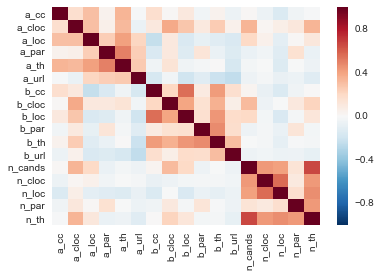

In [7]:
train = annotated_data.loc[(annotated_data['id'].str.contains('test'))] # swap later
valid = annotated_data.loc[(annotated_data['id'].str.contains('validation'))]
test = annotated_data.loc[(annotated_data['id'].str.contains('development'))] # swap later

train_valid = pd.concat([train, valid, test])

answer_columns = ['label']
excl = ['id']
excl += ['a_out', 'b_out']
feature_columns = [col for col in annotated_data.columns if col not in answer_columns and col not in excl]

meta_features_train_valid = train_valid[feature_columns].fillna(0)
meta_features_test = test[feature_columns].fillna(0)

sns.heatmap(meta_features_train_valid.corr())

## Standardization

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
for col in meta_features_train_valid.columns:
    std = MinMaxScaler()
    meta_features_train_valid[col] = std.fit_transform(meta_features_train_valid[col].values.reshape(-1, 1))
    meta_features_test[col] = std.transform(meta_features_test[col].values.reshape(-1, 1))

C:\Users\zake7\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\zake7\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\zake7\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\zake7\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\zake7\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to floa

In [9]:
# Keep all BERTs learn on the same corpus
remove_test = []
remove_validation = []
remove_development = [209, 1506, 1988]

In [10]:
meta_features_train_valid = meta_features_train_valid.values
meta_features_test = meta_features_test.values # These should be fix on the stage 2 because they will use to train
meta_features_test = np.delete(meta_features_test, remove_development, 0)

meta_features_train_valid = np.delete(meta_features_train_valid, remove_test, 0)
meta_features_train_valid = np.delete(meta_features_train_valid, [v + len(train) for v in remove_validation], 0)
meta_features_train_valid = np.delete(meta_features_train_valid, [v + len(train) + len(valid) for v in remove_development], 0)

In [11]:
print("meta_features_train_valid shpae:", meta_features_train_valid.shape)
print("meta_features_test shpae:", meta_features_test.shape)

meta_features_train_valid shpae: (4451, 17)
meta_features_test shpae: (1997, 17)


# NLI Acrhitecture

In [12]:
def build_mlp_model(input_shape, split_size, meta_features_shape):
    X_input = layers.Input(input_shape)
    meta_input = layers.Input(meta_features_shape)

    # First dense layer
    A = layers.Lambda(lambda x: x[:, :split_size])(X_input)
    B = layers.Lambda(lambda x: x[:, split_size:split_size*2])(X_input)
    P = layers.Lambda(lambda x: x[:, split_size*2:])(X_input)

    head_num = 6
    res = []
    for head in range(head_num):
        query_encoder = layers.Dense(dense_layer_sizes[0], activation='selu', kernel_regularizer = regularizers.l2(1e-6))
        ans_encoder = layers.Dense(dense_layer_sizes[0], activation='selu', kernel_regularizer = regularizers.l2(1e-6))
        
        d_ratio = 0.6
        
        a, b = query_encoder(layers.Dropout(d_ratio)(A)), query_encoder(layers.Dropout(d_ratio)(B))
        p = query_encoder(layers.Dropout(d_ratio)(P))
        
        amp = layers.Multiply()([a, p])
        bmp = layers.Multiply()([b, p])
        
        asp = layers.Lambda(lambda v: v[0] - v[1])([p, a])
        bsp = layers.Lambda(lambda v: v[0] - v[1])([p, b])        
        
        ia = layers.Concatenate()([a, p, amp, asp])
        ib = layers.Concatenate()([b, p, bmp, bsp])
        nli_encoder = layers.Dense(dense_layer_sizes[0], activation='selu')
        ia, ib = nli_encoder(ia), nli_encoder(ib)
        
        out = layers.Concatenate()([ia, ib])
        res.append(out)
    
    res = layers.Add()(res)
    res = layers.Dropout(0.8)(res)
    
    meta_out = layers.Dense(20, activation='selu')(meta_input)
    meta_out = layers.Dropout(0.25)(meta_out)    
    
    res = layers.Concatenate()([res, meta_out])
    
    X = layers.Dense(dense_layer_sizes[0], name = 'dense0')(res)
    X = layers.BatchNormalization(name = 'bn0')(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(dropout_rate, seed = 7)(X)

    # Output layer
    X = layers.Dense(3, name = 'output', kernel_regularizer = regularizers.l2(lambd))(X)
    X = layers.Activation('softmax')(X)

    # Create model
    model = models.Model(input = [X_input, meta_input], output = X, name = "classif_model")
    return model

In [13]:
def build_base_nli_model(input_shape, split_size, meta_features_shape):
    X_input = layers.Input(input_shape)
    meta_input = layers.Input(meta_features_shape)

    # First dense layer
    A = layers.Lambda(lambda x: x[:, :split_size])(X_input)
    B = layers.Lambda(lambda x: x[:, split_size:split_size*2])(X_input)
    P = layers.Lambda(lambda x: x[:, split_size*2:])(X_input)

    query_encoder = layers.Dense(512, activation='selu', kernel_regularizer = regularizers.l2(1e-6))
    ans_encoder = layers.Dense(512, activation='selu', kernel_regularizer = regularizers.l2(1e-6))

    d_ratio = 0.6

    a, b = query_encoder(layers.Dropout(d_ratio)(A)), query_encoder(layers.Dropout(d_ratio)(B))
    p = query_encoder(layers.Dropout(d_ratio)(P))

    amp = layers.Multiply()([a, p])
    bmp = layers.Multiply()([b, p])

    asp = layers.Lambda(lambda v: v[0] - v[1])([p, a])
    bsp = layers.Lambda(lambda v: v[0] - v[1])([p, b])        

    ia = layers.Concatenate()([a, p, amp, asp])
    ib = layers.Concatenate()([b, p, bmp, bsp])
    
    nli_encoder = layers.Dense(128, activation='selu')
    ia, ib = nli_encoder(ia), nli_encoder(ib)

    features = layers.Concatenate()([ia, ib])    
    features = layers.Dropout(0.75)(features)
    
    meta_out = layers.Dense(20, activation='selu')(meta_input)
    meta_out = layers.Dropout(0.25)(meta_out)    
    
    res = layers.Concatenate()([features, meta_out])
    
    X = layers.Dense(dense_layer_sizes[0], name = 'dense0')(res)
    X = layers.BatchNormalization(name = 'bn0')(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(dropout_rate, seed = 7)(X)

    # Output layer
    X = layers.Dense(3, name = 'output', kernel_regularizer = regularizers.l2(lambd))(X)
    X = layers.Activation('softmax')(X)

    # Create model
    model = models.Model(input = [X_input, meta_input], output = X, name = "classif_model")
    return model

In [14]:
dev_filename = "contextual_embeddings_gap_development.json"
val_filename = "contextual_embeddings_gap_validation.json"
test_filename = "contextual_embeddings_gap_test.json"

In [15]:
def parse_json(embeddings, embedding_size):
    '''
    Parses the embeddigns given by BERT, and suitably formats them to be passed to the MLP model

    Input: embeddings, a DataFrame containing contextual embeddings from BERT, as well as the labels for the classification problem
    columns: "emb_A": contextual embedding for the word A
             "emb_B": contextual embedding for the word B
             "emb_P": contextual embedding for the pronoun
             "label": the answer to the coreference problem: "A", "B" or "NEITHER"

    Output: X, a numpy array containing, for each line in the GAP file, the concatenation of the embeddings of the target words
            Y, a numpy array containing, for each line in the GAP file, the one-hot encoded answer to the coreference problem
    '''
    embeddings.sort_index(inplace = True) # Sorting the DataFrame, because reading from the json file messed with the order
    X = np.zeros((len(embeddings),3* embedding_size))
    Y = np.zeros((len(embeddings), 3))

    # Concatenate features
    for i in range(len(embeddings)):
        A = np.array(embeddings.loc[i,"emb_A"])
        B = np.array(embeddings.loc[i,"emb_B"])
        P = np.array(embeddings.loc[i,"emb_P"])
        X[i] = np.concatenate((A,B,P))

    # One-hot encoding for labels
    for i in range(len(embeddings)):
        label = embeddings.loc[i,"label"]
        if label == "A":
            Y[i,0] = 1
        elif label == "B":
            Y[i,1] = 1
        else:
            Y[i,2] = 1

    return X, Y

In [16]:
def train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_tag, model_func,
                dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
                oof_folder='oof/', pred_folder='outputs/'):
    '''
    Arguments:
        tag (data_tag): the tag of model and vec
        embedding_size: the size of bert embedding
        layer: to indicate which layer of bert is going to use
        checkpoint_path: the path to model_checkpoint folder
        n_fold: the number of CV folds
        model_tag: the prefix of the prediction and oof file and model chekpoint
    '''

    tag = tag + str(layer) # follow the original naming style
    dev_filename = tag + dev_filename
    val_filename = tag + val_filename
    test_filename = tag + test_filename
    
    development = pd.read_json(os.path.join(dev_folder_path, dev_filename))
    X_development, Y_development = parse_json(development, embedding_size)

    validation = pd.read_json(os.path.join(val_folder_path, val_filename))
    X_validation, Y_validation = parse_json(validation, embedding_size)

    test = pd.read_json(os.path.join(test_folder_path, test_filename))
    X_test, Y_test = parse_json(test, embedding_size)

    # There may be a few NaN values, where the offset of a target word is greater than the max_seq_length of BERT.
    # They are very few, so I'm just dropping the rows.
    # remove_test = [row for row in range(len(X_test)) if np.sum(np.isnan(X_test[row].reshape(-1)))]
    X_test = np.delete(X_test, remove_test, 0)
    Y_test = np.delete(Y_test, remove_test, 0)

    # remove_validation = [row for row in range(len(X_validation)) if np.sum(np.isnan(X_validation[row].reshape(-1)))]
    X_validation = np.delete(X_validation, remove_validation, 0)
    Y_validation = np.delete(Y_validation, remove_validation, 0)

    # We want predictions for all development rows. So instead of removing rows, make them 0
    # remove_development = [row for row in range(len(X_development)) if np.sum(np.isnan(X_development[row].reshape(-1)))]
    X_development = np.delete(X_development, remove_development, 0)
    Y_development = np.delete(Y_development, remove_development, 0)
    
    # Will train on data from the gap-test and gap-validation files, in total 2454 rows
    X_train = np.concatenate((X_test, X_validation, X_development), axis = 0)
    Y_train = np.concatenate((Y_test, Y_validation, Y_development), axis = 0)

    # Will predict probabilities for data from the gap-development file; initializing the predictions
    prediction = np.zeros((len(X_development), 3)) # testing predictions

    # Training and cross-validation
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=3)
    scores = []
    oof = np.zeros_like(Y_train)
    
    print("X_train shape:", X_train.shape)
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train)):
        # split training and validation data
        print('Fold', fold_n, 'started at', time.ctime())
        X_tr, X_val = X_train[train_index], X_train[valid_index]
        meta_X_tr, meta_X_val = meta_features_train_valid[train_index], meta_features_train_valid[valid_index]
        
        Y_tr, Y_val = Y_train[train_index], Y_train[valid_index]
        # Define the model, re-initializing for each fold
        classif_model = model_func([X_train.shape[-1]], split_size=embedding_size, meta_features_shape=[meta_X_tr.shape[-1]])
        classif_model.compile(optimizer=optimizers.Adam(lr=learning_rate), loss="categorical_crossentropy")
        
        callbacks = [kc.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                     kc.ModelCheckpoint(os.path.join(checkpoint_path, model_tag + tag + str(fold_n) + '.pt'), monitor='val_loss', verbose=0, save_best_only=True, mode='min')]

        # train the model
        classif_model.fit(x=[X_tr, meta_X_tr], y=Y_tr, epochs=epochs, batch_size=batch_size, 
                          callbacks=callbacks, validation_data=([X_val, meta_X_val], Y_val), verbose=0)

        # make predictions on validation and test data
        pred_valid = classif_model.predict(x=[X_val, meta_X_val], verbose=0)
        oof[valid_index] = pred_valid
        pred = classif_model.predict(x=[X_development, meta_features_test], verbose=0)

        # oof[valid_index] = pred_valid.reshape(-1,)
        scores.append(log_loss(Y_val, pred_valid))
        prediction += pred
    
    prediction /= n_fold
    
    print("-" * 30)    
    print("For the model", tag)
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    print(scores)
    print("-" * 30)

    # Write the prediction to file for submission
    oof_df = pd.DataFrame(oof)
    oof_df.to_csv(oof_folder + model_tag + tag + ".csv", index=False)

# Bert Base
## Uncased

In [17]:
dev_folder_path = val_folder_path = test_folder_path = "vector/bert_base"
embedding_size = 768
layer = 8
checkpoint_path = "stage_1_checkpoints/"
n_fold = 7
tag = "bert-base-uncased-seq512-"
pred_tag = "Hnli-mh-"
model_func = build_mlp_model

train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_func=model_func,
            dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
            oof_folder='oof/', pred_folder='outputs/', model_tag=pred_tag)

X_train shape: (4451, 2304)
Fold 0 started at Mon Apr 15 17:40:45 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 1 started at Mon Apr 15 17:42:19 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 2 started at Mon Apr 15 17:44:02 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 3 started at Mon Apr 15 17:45:46 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 4 started at Mon Apr 15 17:47:49 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 5 started at Mon Apr 15 17:49:57 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 6 started at Mon Apr 15 17:52:04 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


------------------------------
For the model bert-base-uncased-seq512-8
CV mean score: 0.3830, std: 0.0324.
[0.4075254596511353, 0.3449257137645592, 0.4322493174706392, 0.348008680418703, 0.35015915594813807, 0.3939610126542433, 0.40403216432470196]
------------------------------


In [18]:
pred_tag = "HBnli-mh-"
model_func = build_base_nli_model
train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_func=model_func,
            dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
            oof_folder='oof/', pred_folder='outputs/', model_tag=pred_tag)

X_train shape: (4451, 2304)
Fold 0 started at Mon Apr 15 17:54:06 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 1 started at Mon Apr 15 17:54:41 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 2 started at Mon Apr 15 17:55:24 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 3 started at Mon Apr 15 17:56:02 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 4 started at Mon Apr 15 17:56:44 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 5 started at Mon Apr 15 17:57:32 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 6 started at Mon Apr 15 17:58:15 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


------------------------------
For the model bert-base-uncased-seq512-8
CV mean score: 0.3922, std: 0.0321.
[0.4166922108683905, 0.37443787639330245, 0.4206860749242804, 0.3540055930492565, 0.34413339747341115, 0.4030693225623343, 0.43211035894037053]
------------------------------


## Cased

In [19]:
dev_folder_path = val_folder_path = test_folder_path = "vector/bert_base_cased"
embedding_size = 768
layer = 8
checkpoint_path = "stage_1_checkpoints/"
n_fold = 7
tag = "bert-base-cased-seq512-"
pred_tag = "Hnli-mh-"
model_func = build_mlp_model

train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_func=model_func,
            dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
            oof_folder='oof/', pred_folder='outputs/', model_tag=pred_tag)

X_train shape: (4451, 2304)
Fold 0 started at Mon Apr 15 17:59:18 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 1 started at Mon Apr 15 18:01:09 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 2 started at Mon Apr 15 18:03:15 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 3 started at Mon Apr 15 18:05:31 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 4 started at Mon Apr 15 18:07:43 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 5 started at Mon Apr 15 18:11:11 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 6 started at Mon Apr 15 18:13:29 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


------------------------------
For the model bert-base-cased-seq512-8
CV mean score: 0.4240, std: 0.0239.
[0.45386260306556364, 0.38981875994498255, 0.43333721133317826, 0.4056989710719241, 0.39957923055022637, 0.4332074443868262, 0.4526210846779061]
------------------------------


In [20]:
pred_tag = "HBnli-mh-"
model_func = build_base_nli_model
train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_func=model_func,
            dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
            oof_folder='oof/', pred_folder='outputs/', model_tag=pred_tag)

X_train shape: (4451, 2304)
Fold 0 started at Mon Apr 15 18:15:36 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 1 started at Mon Apr 15 18:16:37 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 2 started at Mon Apr 15 18:17:31 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 3 started at Mon Apr 15 18:18:37 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 4 started at Mon Apr 15 18:19:41 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 5 started at Mon Apr 15 18:20:34 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 6 started at Mon Apr 15 18:21:33 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


------------------------------
For the model bert-base-cased-seq512-8
CV mean score: 0.4371, std: 0.0269.
[0.464022066024258, 0.40939505401385196, 0.4158152336301026, 0.41438739383889733, 0.4214608314723134, 0.45095454739427204, 0.4834893424320585]
------------------------------


# Bert Big
## Uncased

In [21]:
dev_folder_path = val_folder_path = test_folder_path = "vector/bert_big"
embedding_size = 1024
layer = 19
checkpoint_path = "stage_1_checkpoints/"
n_fold = 7
tag = "bert-large-uncased-seq300-"
pred_tag = "Hnli-mh-"
model_func = build_mlp_model

train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_func=model_func,
            dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
            oof_folder='oof/', pred_folder='outputs/', model_tag=pred_tag)

X_train shape: (4451, 3072)
Fold 0 started at Mon Apr 15 18:22:28 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 1 started at Mon Apr 15 18:24:51 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 2 started at Mon Apr 15 18:26:47 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 3 started at Mon Apr 15 18:28:39 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 4 started at Mon Apr 15 18:30:44 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 5 started at Mon Apr 15 18:33:53 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 6 started at Mon Apr 15 18:36:08 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


------------------------------
For the model bert-large-uncased-seq300-19
CV mean score: 0.3212, std: 0.0344.
[0.31264873524603715, 0.3314900736605185, 0.3542036889790874, 0.29333691311811255, 0.25707254346538244, 0.3344267243407312, 0.3651246081237905]
------------------------------


In [22]:
pred_tag = "HBnli-mh-"
model_func = build_base_nli_model
train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_func=model_func,
            dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
            oof_folder='oof/', pred_folder='outputs/', model_tag=pred_tag)

X_train shape: (4451, 3072)
Fold 0 started at Mon Apr 15 18:38:43 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 1 started at Mon Apr 15 18:39:49 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 2 started at Mon Apr 15 18:40:45 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 3 started at Mon Apr 15 18:41:38 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 4 started at Mon Apr 15 18:42:36 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 5 started at Mon Apr 15 18:43:45 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 6 started at Mon Apr 15 18:45:01 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


------------------------------
For the model bert-large-uncased-seq300-19
CV mean score: 0.3195, std: 0.0358.
[0.2958460717499344, 0.33276500916049917, 0.3466795662750414, 0.283970530199051, 0.2664118608112598, 0.33495610881496224, 0.3759759584830443]
------------------------------


## Cased

In [23]:
dev_folder_path = val_folder_path = test_folder_path = "vector/bert_big_cased"
embedding_size = 1024
layer = 18
checkpoint_path = "stage_1_checkpoints/"
n_fold = 7
tag = "bert-large-cased-seq300-"
pred_tag = "Hnli-mh-"
model_func = build_mlp_model

train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_func=model_func,
            dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
            oof_folder='oof/', pred_folder='outputs/', model_tag=pred_tag)

X_train shape: (4451, 3072)
Fold 0 started at Mon Apr 15 18:46:06 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 1 started at Mon Apr 15 18:48:48 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 2 started at Mon Apr 15 18:51:41 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 3 started at Mon Apr 15 18:54:23 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 4 started at Mon Apr 15 18:57:36 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 5 started at Mon Apr 15 19:01:16 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 6 started at Mon Apr 15 19:04:10 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


------------------------------
For the model bert-large-cased-seq300-18
CV mean score: 0.3547, std: 0.0325.
[0.38360660565367594, 0.3250917413908221, 0.37822275997501753, 0.3273997427778975, 0.3023449175557604, 0.3791175045218735, 0.3872600723690478]
------------------------------


In [24]:
pred_tag = "HBnli-mh-"
model_func = build_base_nli_model
train_folds(tag, dev_folder_path, val_folder_path, test_folder_path, embedding_size, layer, checkpoint_path, n_fold, model_func=model_func,
            dev_filename=dev_filename, val_filename=val_filename, test_filename=test_filename,
            oof_folder='oof/', pred_folder='outputs/', model_tag=pred_tag)

X_train shape: (4451, 3072)
Fold 0 started at Mon Apr 15 19:06:38 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 1 started at Mon Apr 15 19:07:56 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 2 started at Mon Apr 15 19:09:38 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 3 started at Mon Apr 15 19:11:06 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 4 started at Mon Apr 15 19:12:41 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 5 started at Mon Apr 15 19:14:29 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Fold 6 started at Mon Apr 15 19:16:06 2019


C:\Users\zake7\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


------------------------------
For the model bert-large-cased-seq300-18
CV mean score: 0.3542, std: 0.0290.
[0.37714972398547697, 0.33950942686417834, 0.35625219269914743, 0.3345003114953204, 0.30358343173507396, 0.3698772181960521, 0.39835306498229844]
------------------------------
